# InceptionV3 on MURA

Directly using InceptionV3 from Keras: https://keras.io/applications

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
#from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
#use multi-gpu & fine-tune model
#from keras.utils.training_utils import multi_gpu_model
#use new file name after install the BN fix version Keras 2.1.6 fork
from keras.utils.multi_gpu_utils import multi_gpu_model
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Sequential

# show autotime
%load_ext autotime

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True) #walter: auto detect running kernel
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 562 ms


## Loading Data

Loading MURA images

In [3]:
import utils # importing from our utils functions

time: 8.6 s


In [4]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle(y_output=14)

INFO:utils.utils:loading /home/walte/data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading /home/walte/data/MURA-v1.1/y_train_14.pkl
INFO:utils.utils:loading /home/walte/data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading /home/walte/data/MURA-v1.1/y_valid_14.pkl


time: 51.9 s


We can look at the shape of the dataset:

In [5]:
#x_train.shape

time: 597 µs


In [6]:
#y_train.shape

time: 1.03 ms


In [7]:
size = x_train.shape[1]

time: 1.1 ms


Visually inspect an image:

In [8]:
#from matplotlib import pyplot as plt
#%matplotlib inline
#plt.imshow(x_train[0])

time: 880 µs


## Data preparation

in order to use pre-trained model, needs to use 224 x 224 x3 input format

Convert our data type to float16(or float32 if memory is not ans issue) and normalize our data values to the range [0, 1].

In [9]:
print("%d bytes" % (x_train.size * x_train.itemsize))
print("%d bytes" % (x_test.size * x_test.itemsize))

5540634624 bytes
481238016 bytes
time: 1.62 ms


In [10]:
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

time: 2min 2s


In [11]:
print("%d bytes" % (x_train.size * x_train.itemsize))
print("%d bytes" % (x_test.size * x_test.itemsize))

11081269248 bytes
962476032 bytes
time: 1.62 ms


even though we have a 0-1 target, it's easier if we frame it in terms of a 2-class classification task.

In [12]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

time: 20.9 ms


In [13]:
y_train.shape

(36808, 14)

time: 3.38 ms


In [14]:
#datagen = ImageDataGenerator(
#    rotation_range=360,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=[1, 1.2],
#    fill_mode = 'constant',
#    cval=0,
#    horizontal_flip=True,
#    vertical_flip=True)

time: 1.84 ms


In [15]:
#import gc
#gc.collect()

time: 1.01 ms


In [16]:
#with tf.device('/device:CPU:0'):
#datagen.fit(x_train)

time: 895 µs


## Define model architecture

In [17]:
#check original model
#base_model = InceptionV3(include_top=True, weights='imagenet')
#print(base_model.summary())

time: 870 µs


In [18]:
#base_model.layers[170].name

time: 860 µs


In [19]:
# declare sequential model
with tf.device('/device:CPU:0'):
    # create the base pre-trained model
    base_model = InceptionV3(include_top=False, weights='imagenet')
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer, turn-off to try
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 2 classes
    predictions = Dense(14, activation='softmax')(x)
    # this is the model we will train
    bmodel = Model(inputs=base_model.input, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False


time: 8min 3s


In [19]:
# if i have a save model, then just load it
with tf.device('/device:CPU:0'):
    bmodel = load_model('./trained_models/InceptionV3_mura14_tf60.h5')
print(bmodel.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

/home/shared/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
len(bmodel.layers)

314

time: 7.53 ms


In [21]:
#use multi gpus
model = multi_gpu_model(bmodel, gpus=2)

time: 18.4 s


In [22]:
model.output_shape

(None, 14)

time: 2.03 ms


In [23]:
#adam = optimizers.Adam(amsgrad=False) #try later

time: 23.8 ms


In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

time: 31.6 ms


## Fitting the model

### First 10 epoches

In [25]:
model.fit(x=x_train, y=y_train, validation_split=0.0, batch_size=128, epochs=5, verbose=1)

Epoch 1/5
36808/36808 [==============================] - 226s 6ms/step - loss: 0.0716 - acc: 0.9811
Epoch 2/5
36808/36808 [==============================] - 178s 5ms/step - loss: 0.0529 - acc: 0.9843
Epoch 3/5
36808/36808 [==============================] - 178s 5ms/step - loss: 0.0485 - acc: 0.9849
Epoch 4/5
36808/36808 [==============================] - 178s 5ms/step - loss: 0.0464 - acc: 0.9850
Epoch 5/5
36808/36808 [==============================] - 177s 5ms/step - loss: 0.0489 - acc: 0.9851


time: 15min 36s


In [26]:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=128), 
#                    steps_per_epoch = len(x_train) / 128, epochs=10, verbose=1)

time: 894 µs


In [27]:
bmodel.save('./trained_models/InceptionV3_mura14_tf65.h5')

time: 39.2 s


We can check how loss and accuracy change over epochs

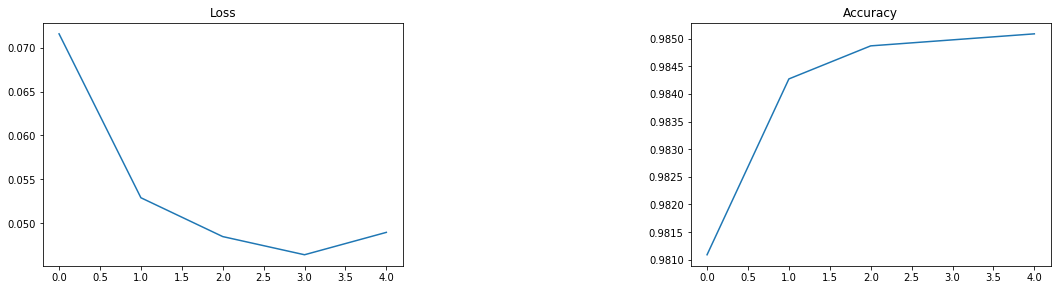

time: 425 ms


In [28]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [29]:
x_test.shape
#y_test.shape

(3197, 224, 224, 3)

time: 2.5 ms


In [30]:
# need to be float32, cannot be showed if use float16
#plt.imshow(x_test[0])

time: 709 µs


In [31]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

time: 2.93 ms


In [32]:
score = model.evaluate(x_test, y_test, verbose=1)

3197/3197 [==============================] - 36s 11ms/step
time: 35.8 s


In [33]:
score

[3.256071437922798, 0.6334063183303024]

time: 2.58 ms


In [34]:
test1 = model.predict(x_test[0:1]); test1

array([[2.8077213e-10, 1.6595067e-15, 4.9909099e-10, 4.9723099e-12,
        2.4353977e-17, 2.7265236e-05, 2.9126868e-01, 1.4204502e-12,
        2.8118158e-10, 4.2581599e-10, 1.7761358e-17, 1.4674816e-19,
        4.7771441e-17, 7.0870405e-01]], dtype=float32)

time: 18.5 s


In [35]:
#x_test[0:1]

time: 661 µs


In [36]:
# compute predicted y
y_test_pred = model.predict(x_test)

time: 18.5 s


In [37]:
#check y_test_hat
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_pred, axis=1)

time: 1.89 ms


In [38]:
# get actual digit labels
true_label

array([13, 13, 13, ...,  1,  1,  1])

time: 2.74 ms


In [39]:
pred_label

array([13,  6,  6, ...,  8,  1,  1])

time: 2.65 ms


### Cohen's Kappa

In [40]:
# use sci-learn to draw cm
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(true_label, pred_label)

time: 5.58 ms


In [41]:
# team2 method
#p_observed = (true_label == pred_label).sum()/true_label.shape[0]
#p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])
#kappa = (p_observed - p_expected) / (1 - p_expected)

time: 1.05 ms


In [42]:
kappa

0.6018740444335922

time: 2.57 ms


[[153   3   5   0   1   4   3  64   0   0   0   0   2   0]
 [  2 153   2   7   0   0   2   0  40   0   8   0   0   0]
 [ 11   2  99   2   3   1   8   3   1  19   0   0   1   0]
 [  0   4   0 208   0   0   9   0   4   0  41   0   2   3]
 [  5   4   8   1  94   3   0   1   0   0   1  30   0   1]
 [  0   0   0   1   0 175   0   1   0   0   0   0 108   0]
 [  0   2   5   0   0   3 288   0   4   0   1   0   1  60]
 [ 39   2   3   0   0   2   2 166   0   5   0   0   4   7]
 [  0 102   0   6   0   0   3   1 125   0   7   0   0   3]
 [  3   4  49   0   0   4   6  17   1  47   0   2   6  12]
 [  0   1   0  93   0   0  11   0   5   0  77   0   0   2]
 [  3   1   6   0  23   4   3  10   1   2   1  75  10   1]
 [  3   2   0   0   1  80   0   1   0   0   0   0 190   1]
 [  1   1   0   2   0   0 104   3   4   3   2   0   0 175]]


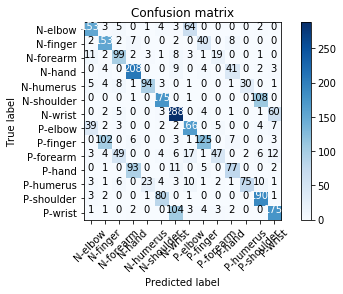

time: 786 ms


In [43]:
#'ELBOW':0, 'FINGER':1, 'FOREARM':2, 'HAND':3, 'HUMERUS':4, 'SHOULDER':5, 'WRIST':6
utils.plot_confusion_matrix(true_label, pred_label, \
                            ('N-elbow', 'N-finger', 'N-forearm', 'N-hand', 'N-humerus', 'N-shoulder', 'N-wrist', \
                            'P-elbow', 'P-finger', 'P-forearm', 'P-hand', 'P-humerus', 'P-shoulder', 'P-wrist'))

In [45]:
#with tf.device('/device:CPU:0'):
#    bmodel = load_model('./trained_models/InceptionV3_mura_tf30.h5')

time: 867 µs


### More epoches 11-60

In [46]:
# need to do validation split later since most of the samples are hand at the end 15% of input set
model.fit(x=x_train, y=y_train, validation_split=0.0, batch_size=128, epochs=50, verbose=1)

Epoch 1/50
36808/36808 [==============================] - 173s 5ms/step - loss: 0.4313 - acc: 0.8122
Epoch 2/50
36808/36808 [==============================] - 174s 5ms/step - loss: 0.4033 - acc: 0.8271
Epoch 3/50
36808/36808 [==============================] - 174s 5ms/step - loss: 0.3743 - acc: 0.8382
Epoch 4/50
36808/36808 [==============================] - 174s 5ms/step - loss: 0.3448 - acc: 0.8532
Epoch 5/50
36808/36808 [==============================] - 176s 5ms/step - loss: 0.3219 - acc: 0.8616
Epoch 6/50
36808/36808 [==============================] - 176s 5ms/step - loss: 0.2954 - acc: 0.8763
Epoch 7/50
36808/36808 [==============================] - 175s 5ms/step - loss: 0.2794 - acc: 0.8849
Epoch 8/50
36808/36808 [==============================] - 173s 5ms/step - loss: 0.2601 - acc: 0.8911
Epoch 9/50
36808/36808 [==============================] - 174s 5ms/step - loss: 0.2389 - acc: 0.9018
Epoch 10/50
36808/36808 [==============================] - 179s 5ms/step - loss: 0.2204 - a

time: 2h 26min 46s


In [47]:
bmodel.save('./trained_models/InceptionV3_mura14_tf60.h5')

time: 534 ms


We can check how loss and accuracy change over epochs

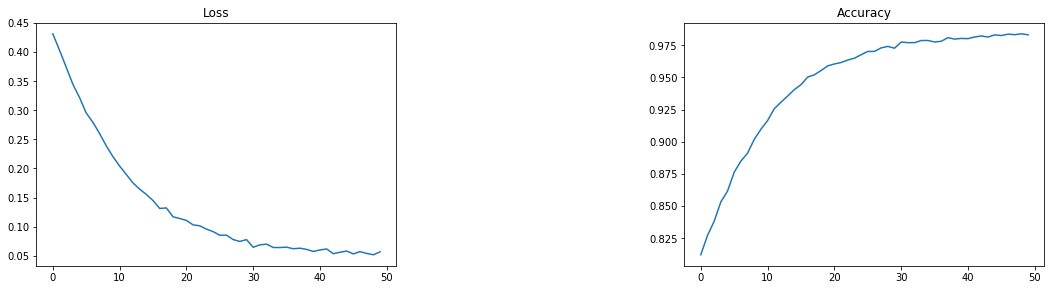

time: 245 ms


In [48]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [49]:
#with tf.device('/device:CPU:0'):
#    bmodel = load_model('./trained_models/InceptionV3_mura_tf60.h5')

time: 717 µs


## Evaluating our model on the test set

### Loss and Accuracy

In [50]:
score = model.evaluate(x_test, y_test, verbose=1); score

3197/3197 [==============================] - 18s 6ms/step


[3.1039644461480536, 0.6399749762794917]

time: 18.2 s


In [51]:
# compute predicted y
y_test_pred = model.predict(x_test)

time: 18.2 s


In [52]:
# get actual digit labels
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_pred, axis=1)

time: 1.77 ms


### Cohen's Kappa

In [53]:
# use sci-learn to draw cm
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(true_label, pred_label); kappa

0.6094276012079283

time: 6.89 ms


[[155   3   2   0   1   4   2  66   0   1   0   1   0   0]
 [  2 162   1   8   0   0   1   0  31   1   7   0   1   0]
 [  5   1  92   0   4   1  10   7   0  28   0   0   1   1]
 [  0   6   0 213   0   0   4   2   1   0  39   2   2   2]
 [  5   4   7   2  88   2   0   1   0   1   1  36   1   0]
 [  0   0   0   1   1 181   0   2   0   0   0   0 100   0]
 [  1   4   2   1   0   2 275   2   2   1   1   1   1  71]
 [ 43   0   1   0   0   0   2 168   0   5   0   1   8   2]
 [  0 126   0   5   0   0   0   1 106   0   6   1   1   1]
 [  3   1  30   1   0   2   4  17   1  74   0   6   6   6]
 [  0   3   0  92   0   0   5   1   3   1  82   0   0   2]
 [  2   1   2   0  17   1   2  13   0   9   0  87   5   1]
 [  2   2   0   0   1  84   0   3   0   0   1   2 182   1]
 [  0   3   1   4   0   0  89   8   2   4   2   0   1 181]]


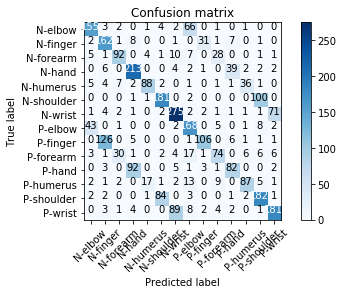

time: 724 ms


In [54]:
#'ELBOW':0, 'FINGER':1, 'FOREARM':2, 'HAND':3, 'HUMERUS':4, 'SHOULDER':5, 'WRIST':6
utils.plot_confusion_matrix(true_label, pred_label, \
                            ('N-elbow', 'N-finger', 'N-forearm', 'N-hand', 'N-humerus', 'N-shoulder', 'N-wrist', \
                            'P-elbow', 'P-finger', 'P-forearm', 'P-hand', 'P-humerus', 'P-shoulder', 'P-wrist'))